In [94]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt

## read training data

In [132]:
train = pd.read_csv('train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## index = id, target = Sales Price

In [135]:
# set column Id as index
train.drop(['Id'],axis=1,inplace=True)
# set SalePrice as target column
y = train['SalePrice']
# remove SalePrice from training data
train = train.iloc[:,:-1]
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [136]:
temp = train.isnull().any()
cols_na = temp[temp==True].index.tolist()
train_na = train.loc[:,cols_na].isnull().astype(int).mean().sort_values(ascending=False)
train_na

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

## divide training data into numeric and categoric variables

In [137]:
# numeric data
train_numeric = train._get_numeric_data()
# all columns
cols_all = train.columns.tolist()
# numeric columns
cols_numeric = train_numeric.columns.tolist()
# categoric columns
cols_categoric = list(set(cols_all)-set(cols_numeric))
# categoric data
train_categoric = train.loc[:,cols_categoric]
train_categoric.head()

,BsmtQual,LandSlope,Functional,HouseStyle,GarageFinish,Foundation,KitchenQual,MiscFeature,BsmtFinType1,Electrical,...,LotConfig,Heating,Condition2,BsmtExposure,BsmtFinType2,GarageType,RoofStyle,RoofMatl,BldgType,Exterior1st
0,Gd,Gtl,Typ,2Story,RFn,PConc,Gd,NaN,GLQ,SBrkr,...,Inside,GasA,Norm,No,Unf,Attchd,Gable,CompShg,1Fam,VinylSd
1,Gd,Gtl,Typ,1Story,RFn,CBlock,TA,NaN,ALQ,SBrkr,...,FR2,GasA,Norm,Gd,Unf,Attchd,Gable,CompShg,1Fam,MetalSd
2,Gd,Gtl,Typ,2Story,RFn,PConc,Gd,NaN,GLQ,SBrkr,...,Inside,GasA,Norm,Mn,Unf,Attchd,Gable,CompShg,1Fam,VinylSd
3,TA,Gtl,Typ,2Story,Unf,BrkTil,Gd,NaN,ALQ,SBrkr,...,Corner,GasA,Norm,No,Unf,Detchd,Gable,CompShg,1Fam,Wd Sdng
4,Gd,Gtl,Typ,2Story,RFn,PConc,Gd,NaN,GLQ,SBrkr,...,FR2,GasA,Norm,Av,Unf,Attchd,Gable,CompShg,1Fam,VinylSd


## extract and encode NAs from numeric columns into new variables

In [138]:
# find columns containing at least one NA
cols_numeric_na = train_numeric.columns[train_numeric.isnull().any()].tolist()
# create new variables that encode NAs in numeric variables
train_numeric_na = train_numeric.loc[:,cols_numeric_na].isnull().astype(int)
# add suffix Absent to column names
train_numeric_na.columns = list(map(lambda x: x + '_Absent',cols_numeric_na))
train_numeric_na.head()

,LotFrontage_Absent,MasVnrArea_Absent,GarageYrBlt_Absent
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


## impute NAs in numeric variables

In [139]:
# fill NA by value 0 (Lot Frontage is absent)
train_numeric['LotFrontage'].fillna(value = 0,inplace=True)
# fill NA by value 0 (MasVnrArea is absent)
train_numeric['MasVnrArea'].fillna(value = 0,inplace=True)
# fill NA by value 0 (MasVnrArea is absent)
train_numeric['GarageYrBlt'].fillna(value = int(train_numeric['GarageYrBlt'].mode()),inplace=True )

In [140]:
# encode categoric variables
train_categoric_encoded = pd.get_dummies(train_categoric)
cols_categoric_encoded = train_categoric_encoded.columns.tolist()
train_categoric_encoded.head()
# change names NA -> ...

,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Functional_Maj1,Functional_Maj2,Functional_Min1,...,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [141]:
# combine numeric columns, encoded categoric columns, encoded NAs in numeric columns
X = pd.concat([train_categoric_encoded,train_numeric,train_numeric_na],axis=1)
cols = X.columns.tolist()
X.head()

,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Functional_Maj1,Functional_Maj2,Functional_Min1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotFrontage_Absent,MasVnrArea_Absent,GarageYrBlt_Absent
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,2,2008,0,0,0
1,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,5,2007,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,9,2008,0,0,0
3,0,0,0,1,1,0,0,0,0,0,...,272,0,0,0,0,2,2006,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,12,2008,0,0,0


In [142]:
## standardize all variables

In [143]:
X = (X - X.mean())/X.std()
X.head()

,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Functional_Maj1,Functional_Maj2,Functional_Min1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotFrontage_Absent,MasVnrArea_Absent,GarageYrBlt_Absent
0,-0.300506,-0.156667,1.166845,-0.894259,0.23749,-0.215785,-0.094752,-0.098363,-0.058601,-0.147237,...,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,-1.598563,0.138730,-0.464226,-0.074202,-0.242277
1,-0.300506,-0.156667,1.166845,-0.894259,0.23749,-0.215785,-0.094752,-0.098363,-0.058601,-0.147237,...,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,-0.488943,-0.614228,-0.464226,-0.074202,-0.242277
2,-0.300506,-0.156667,1.166845,-0.894259,0.23749,-0.215785,-0.094752,-0.098363,-0.058601,-0.147237,...,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,0.990552,0.138730,-0.464226,-0.074202,-0.242277
3,-0.300506,-0.156667,-0.856425,1.117479,0.23749,-0.215785,-0.094752,-0.098363,-0.058601,-0.147237,...,4.091122,-0.116299,-0.270116,-0.068668,-0.087658,-1.598563,-1.367186,-0.464226,-0.074202,-0.242277
4,-0.300506,-0.156667,1.166845,-0.894259,0.23749,-0.215785,-0.094752,-0.098363,-0.058601,-0.147237,...,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,2.100173,0.138730,-0.464226,-0.074202,-0.242277


## apply lasso model

In [157]:
lassocv = LassoCV(cv=10,n_alphas=1000)

In [145]:
reg = lassocv.fit(X,y)

No handles with labels found to put in legend.


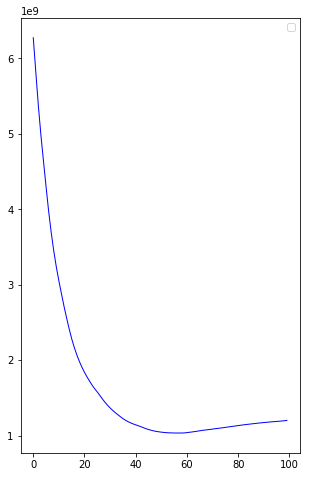

In [146]:
#reg.alphas_
mse_path = np.mean(reg.mse_path_,axis=1)
fig = plt.figure(figsize=(5,8))
plt.plot(mse_path,color='blue',linewidth=1)
#plt.plot(df_y['y_estimated'].tolist(),color='black',linewidth=0.1)
plt.legend()
plt.show()

In [147]:
reg.score(X,y)

0.9115229469713266

In [148]:
coefs = pd.Series(reg.coef_.tolist(),index=cols)
coefs = coefs[coefs!=0]
print(len(coefs))
coefs = coefs.sort_values(ascending=False)
coefs_pos = coefs[coefs>0].sort_values(ascending=False)
coefs_pos = coefs[coefs<0].sort_values()

65


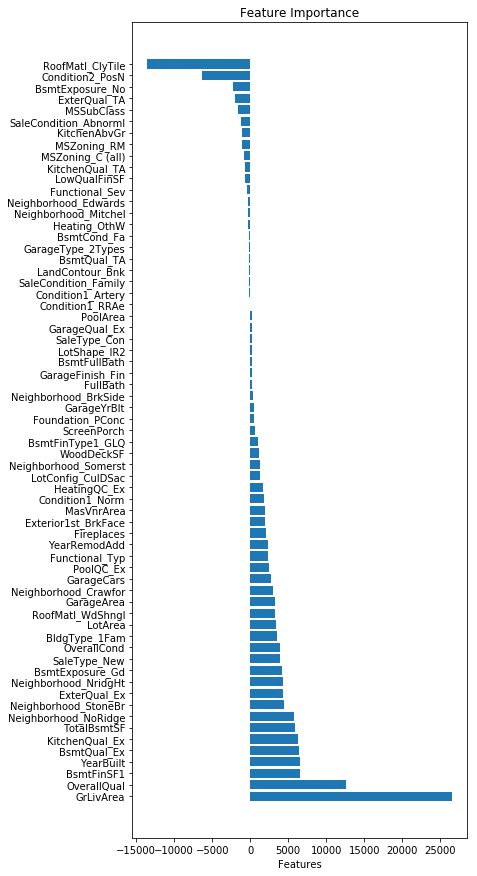

In [149]:
objects = coefs.index.tolist()
y_arange = np.arange(len(objects))
values = coefs.tolist()
fig = plt.figure(figsize=(6,15))
plt.barh(y_arange, values, align='center')
plt.yticks(y_arange, objects)
plt.xlabel('Features')
plt.title('Feature Importance')
plt.show()

In [150]:
# intercept is an average of sale prices
reg.intercept_

180921.19589041092

## estimate sale prices

In [151]:
y_estimated = lassocv.predict(X)
df_y = pd.DataFrame({'y':y,'y_estimated':y_estimated}).sort_values('y')
df_y.head()

,y,y_estimated
495,34900,55175.392763
916,35311,27486.709232
968,37900,56206.645035
533,39300,16399.454685
30,40000,89005.005054


## plot actual and estimated sale prices

No handles with labels found to put in legend.


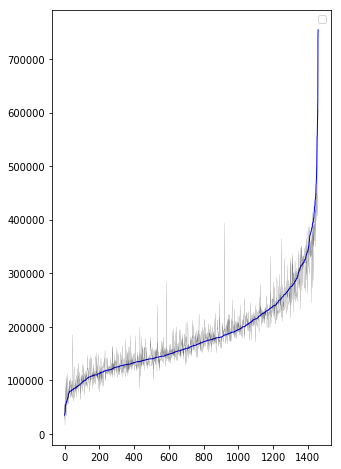

In [152]:
fig = plt.figure(figsize=(5,8))
plt.plot(df_y['y'].tolist(),color='blue',linewidth=1)
plt.plot(df_y['y_estimated'].tolist(),color='black',linewidth=0.1)
plt.legend()
plt.show()

## 10-fold cross-validation

In [160]:
repeatedkfold = RepeatedKFold()
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=2652124)
sample = range(0,X.shape[0])
train_score = []
test_score = []
iteration = 1
for train_index, test_index in rkf.split(sample):
    print('iteration {}'.format(iteration))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    reg = lassocv.fit(X_train,y_train)
    train_score.append(reg.score(X_train,y_train))
    test_score.append(reg.score(X_test,y_test))
    iteration += 1
print('train_score={}'.format(train_score))
print('test_score={}'.format(test_score))

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
train_score=[0.9110997255864774, 0.9150539295512685, 0.9084996917254502, 0.9115132304091884, 0.9129059502508308, 0.9218172592694586, 0.9086586436852735, 0.9119094151610985, 0.9214078017155554, 0.9082456712597529]
test_score=[0.8822792057986248, 0.8665681028201279, 0.5453629493034102, 0.8952055874159524, 0.8899998440110402, 0.7006897388737344, 0.8778928421740136, 0.8947406905477353, 0.8229764049751875, 0.9099953129930505]


In [165]:
print('mean train_score: {}'.format(np.mean(np.array(train_score))))
print('std train_score: {}'.format(np.std(np.array(train_score))))
print('mean test_score: {}'.format(np.mean(np.array(test_score))))
print('std test_score: {}'.format(np.std(np.array(test_score))))

mean train_score: 0.9131111318614353
std train_score: 0.004703762884170609
mean test_score: 0.8285710678912878
std test_score: 0.11071347232316452
